In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from prophet import Prophet



c:\Users\Wael Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
df = pd.read_csv(r"D:\Mostafa's Work\Retail Sales Analytics System\Dataset\archive\mock_kaggle.csv")   


# Load the retail sales dataset from CSV file
# This reads the raw sales data into a pandas DataFrame

In [39]:
print(df.head())


        data  venda  estoque  preco  receita
0 2014-01-01      0     4972   1.29     0.00
1 2014-01-02     70     4902   1.29    90.30
2 2014-01-03     59     4843   1.29    76.11
3 2014-01-04     93     4750   1.29   119.97
4 2014-01-05     96     4654   1.29   123.84


print(df.info())


In [41]:
print(df.describe())


                                data       venda      estoque       preco  \
count                            927  927.000000   927.000000  927.000000   
mean   2015-04-20 06:40:46.601941760   91.510248  1617.749730    1.609752   
min              2014-01-01 00:00:00    0.000000     0.000000    0.930000   
25%              2014-09-01 12:00:00   35.000000   794.000000    1.290000   
50%              2015-04-21 00:00:00   77.000000  1358.000000    1.390000   
75%              2015-12-09 12:00:00  127.500000  1966.000000    1.890000   
max              2016-07-31 00:00:00  542.000000  7228.000000    2.980000   
std                              NaN   80.563201  1359.489609    0.505682   

         receita  
count  927.00000  
mean   149.82507  
min      0.00000  
25%     54.34000  
50%    113.52000  
75%    210.01500  
max    870.24000  
std    144.24705  


# Show data types, column names, and missing values
# Helps understand data quality before cleaning

In [42]:
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values('data')


# Convert the 'data' column from text to datetime format
# Required for time-based analysis and forecasting
# Sort data by date to keep chronological order



In [43]:
df['receita'] = df['venda'] * df['preco']


# Create revenue column
# Revenue = units sold * price

In [44]:
print("Missing values:\n", df.isnull().sum())
print("Negative sales:", (df['venda'] < 0).sum())
print("Zero price rows:", (df['preco'] == 0).sum())


Missing values:
 data       0
venda      0
estoque    0
preco      0
receita    0
dtype: int64
Negative sales: 0
Zero price rows: 0


In [48]:
df = df[df['preco'] > 0]


# Remove rows where price equals zero
# Price = 0 is considered invalid data and would distort analysis

In [50]:
df.loc[df['receita'].idxmax(), ['data','venda','preco','receita']]


data       2016-06-05 00:00:00
venda                      336
preco                     2.59
receita                 870.24
Name: 880, dtype: object

# Find the day with highest revenue
# Helps identify peak performance day

In [51]:
df['receita'].mean()


np.float64(149.82507011866238)

# Calculate average daily revenue
# Represents normal daily business performance

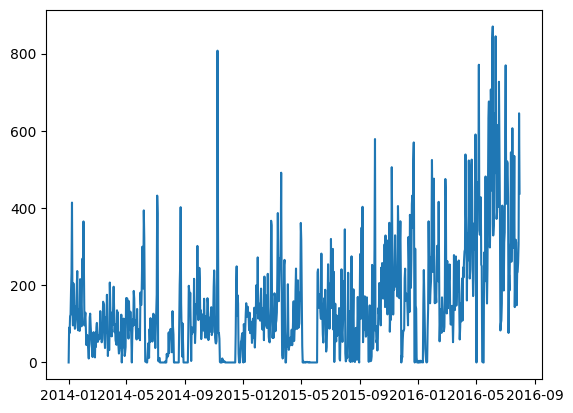

In [52]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['data'], df['receita'])
plt.show()


# Create a line chart showing revenue over time
# X-axis: date (time progression)
# Y-axis: daily revenue
# This visualization helps identify trends, seasonality,
# and unusual spikes or drops in sales performance.

In [54]:
df[['venda','estoque']].corr()


,venda,estoque
venda,1.000000,0.147289
estoque,0.147289,1.000000


# Check relationship between sales and inventory
# Shows if higher stock leads to higher sales


In [55]:
df[['venda','preco']].corr()


,venda,preco
venda,1.000000,0.061832
preco,0.061832,1.000000


# Check relationship between sales and price
# Shows if price changes affect number of items sold

In [56]:

df.groupby(df['data'].dt.month)['receita'].mean()


data
1     126.593111
2     142.807711
3     140.949560
4     164.854667
5     153.865824
6     228.608539
7     189.845393
8      69.927167
9     110.581833
10    150.441774
11    143.520500
12    128.463548
Name: receita, dtype: float64

# Calculate average revenue for each month
# Helps identify seasonal sales patterns

<Axes: xlabel='data'>

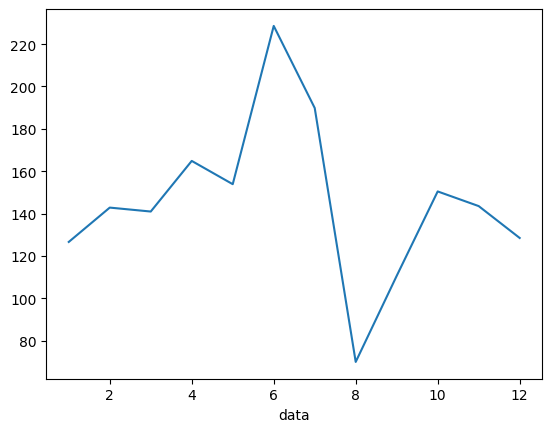

In [57]:
monthly_rev = df.groupby(df['data'].dt.month)['receita'].mean()

monthly_rev.plot()


# Calculate average monthly revenue and plot it
# Used to visualize seasonal trends in sales

In [58]:
total_revenue = df['receita'].sum()
avg_daily_revenue = df['receita'].mean()
best_month = df.groupby(df['data'].dt.month)['receita'].sum().idxmax()

print("Total revenue:", total_revenue)
print("Average daily revenue:", avg_daily_revenue)
print("Best sales month:", best_month)


Total revenue: 138887.84000000003
Average daily revenue: 149.82507011866238
Best sales month: 6


# Get the name of the month with highest revenue
# Converts best month number into readable month name


# Calculate main business KPIs:
# total revenue, average daily revenue, and best sales month

In [59]:
best_month_name = df['data'].dt.month_name().iloc[
    df.groupby(df['data'].dt.month)['receita'].sum().idxmax() - 1
]

print(f"Revenue peaks during {best_month_name}.")


Revenue peaks during January.


# Find the month name with the highest revenue


In [60]:
df.to_csv("clean_retail_sales.csv", index=False)


# Save cleaned dataset for reuse
# Avoids repeating cleaning steps in future runs
df.to_csv("clean_retail_sales.csv", index=False)


In [ ]:
conn = sqlite3.connect("retail_sales.db")
df.to_sql("fact_sales", conn, if_exists="replace", index=False)


# Create/connect to database file
# Save cleaned data into SQL table
# This allows fast querying and dashboard integration

In [64]:
pd.read_sql("""
SELECT 
    SUM(receita) AS total_revenue,
    AVG(receita) AS avg_daily_revenue
FROM fact_sales
""", conn)


,total_revenue,avg_daily_revenue
0,138887.84,149.82507


# Query total and average revenue directly from database
# Demonstrates analytics using SQL instead of pandas

The Highest Month

In [66]:
insight = f"""
Retail Sales Insight Report
---------------------------
Total revenue: {total_revenue:.2f}
Average daily revenue: {avg_daily_revenue:.2f}
Revenue peaks during {best_month_name}.
"""

print(insight)



Retail Sales Insight Report
---------------------------
Total revenue: 138887.84
Average daily revenue: 149.83
Revenue peaks during January.



In [68]:
report = f"""
Retail Sales Insight Report
---------------------------
Total revenue: {total_revenue:,.2f}
Average daily revenue: {avg_daily_revenue:,.2f}
Best month: {best_month_name} (#{best_month})

Key insight:
Revenue is seasonal: it peaks in {best_month_name} and drops in weaker months (like August in your earlier monthly averages).
"""
print(report)



Retail Sales Insight Report
---------------------------
Total revenue: 138,887.84
Average daily revenue: 149.83
Best month: June (#6)

Key insight:
Revenue is seasonal: it peaks in June and drops in weaker months (like August in your earlier monthly averages).



In [69]:
with open("insight_report.txt", "w", encoding="utf-8") as f:
    f.write(report)

print("Saved: insight_report.txt")


Saved: insight_report.txt


In [70]:
pd.read_sql("""
SELECT 
    strftime('%Y-%m', data) AS month,
    SUM(receita) AS revenue
FROM fact_sales
GROUP BY month
ORDER BY month
""", conn)


,month,revenue
0,2014-01,4528.55
1,2014-02,2182.82
2,2014-03,2536.76
3,2014-04,2297.30
4,2014-05,3241.91
5,2014-06,3328.54
6,2014-07,1527.10
7,2014-08,1849.36
8,2014-09,2818.65
9,2014-10,3609.25


In [72]:
import pandas as pd
import calendar

kpis = pd.read_sql("""
SELECT 
  SUM(receita) AS total_revenue,
  AVG(receita) AS avg_daily_revenue
FROM fact_sales
""", conn)

monthly = pd.read_sql("""
SELECT 
  CAST(strftime('%m', data) AS INT) AS month,
  SUM(receita) AS revenue
FROM fact_sales
GROUP BY month
ORDER BY revenue DESC
""", conn)

total_revenue = float(kpis.loc[0, "total_revenue"])
avg_daily_revenue = float(kpis.loc[0, "avg_daily_revenue"])

best_month = int(monthly.iloc[0]["month"])
best_month_name = calendar.month_name[best_month]

top2 = monthly.head(2)
second_month = int(top2.iloc[1]["month"])
second_name = calendar.month_name[second_month]

worst = monthly.tail(1)
worst_month = int(worst.iloc[0]["month"])
worst_name = calendar.month_name[worst_month]

report = f"""
Retail Sales Insight Report
---------------------------
Total revenue: {total_revenue:,.2f}
Average daily revenue: {avg_daily_revenue:,.2f}

Insights:
- Revenue peaks in {best_month_name} (strongest month).
- {second_name} is the second strongest month.
- The weakest month is {worst_name}, suggesting a seasonal dip.
"""

print(report)



Retail Sales Insight Report
---------------------------
Total revenue: 138,887.84
Average daily revenue: 149.83

Insights:
- Revenue peaks in June (strongest month).
- July is the second strongest month.
- The weakest month is August, suggesting a seasonal dip.



In [76]:
forecast_df = df[['data', 'receita']].copy()
forecast_df.columns = ['ds', 'y']
forecast_df.head()


,ds,y
0,2014-01-01,0.00
1,2014-01-02,90.30
2,2014-01-03,76.11
3,2014-01-04,119.97
4,2014-01-05,123.84


# Prepare data for forecasting model
# Prophet requires columns named 'ds' (date) and 'y' (value)

In [78]:
model = Prophet()
model.fit(forecast_df)

14:15:40 - cmdstanpy - INFO - Chain [1] start processing
14:15:41 - cmdstanpy - INFO - Chain [1] done processing


# Train forecasting model on historical revenue data


In [81]:
future = model.make_future_dataframe(periods=90, freq='D')
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1012,2016-10-25,471.147578,343.873502,591.015226
1013,2016-10-26,519.612618,394.666296,655.007877
1014,2016-10-27,502.661934,373.277529,637.774196
1015,2016-10-28,525.705145,390.756502,652.740172
1016,2016-10-29,617.967378,492.219949,751.803018


# Create future dates and predict future revenue


In [83]:
import sqlite3

forecast_out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_out.columns = ['date', 'pred_revenue', 'pred_lower', 'pred_upper']

forecast_out.to_sql("forecast_revenue", conn, if_exists="replace", index=False)

pd.read_sql("SELECT * FROM forecast_revenue LIMIT 5", conn)


,date,pred_revenue,pred_lower,pred_upper
0,2014-01-01 00:00:00,71.182261,-57.086735,207.908525
1,2014-01-02 00:00:00,42.539407,-88.147683,170.028067
2,2014-01-03 00:00:00,54.905062,-75.010827,191.190200
3,2014-01-04 00:00:00,137.745267,10.093586,269.922460
4,2014-01-05 00:00:00,64.978912,-63.112462,189.759834
